# Convolutionalization

In this notebook, we explain the idea of convolutionalization, working with mnist digits.

Convolutionalization is the process of transforming a neural network containing dense layers (typically some classification network) into a fully convolutional one.

The fully convolutional network can be used as a detector kernel, convolving it over an input image to produce a "heat map" of the locations where objects are found.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, GlobalMaxPool2D, MaxPool2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

Here we load the mnist dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000,28,28,1)/255.
x_test = x_test.reshape(10000,28,28,1)/255.
print(x_train.shape)
print(x_train.min())
print(x_train.max())

(60000, 28, 28, 1)
0.0
1.0


It is convenient to add to the detector a "background" class, containing no object. For traning and testing we create a bunch of images "almost black" (to be refined as an exercise).

In [3]:
background = np.random.randint(0,5,(6000,28,28,1))/255. # random train
background_test = np.random.randint(0,5,(1000,28,28,1))/255. # random test 

Let us see an example of background, together with a typical image.

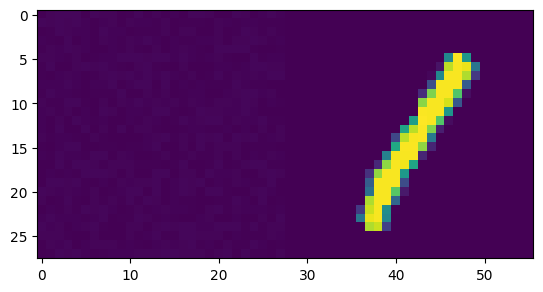

In [4]:
imageplot = plt.imshow(np.reshape(np.concatenate((background[15],x_train[23]),axis=1),(28,56)))
plt.show()

We extend the training set. Backgound gets label "10".

In [5]:
x_train_bg = np.concatenate((x_train,background))
x_test_bg = np.concatenate((x_test,background_test))
y_train_bg = np.concatenate((y_train,np.ones(6000)*10))
y_test_bg = np.concatenate((y_test,np.ones(1000)*10))

In [6]:
print(x_train_bg.shape)

(66000, 28, 28, 1)


The classifier is composed by an initial part made by 2Dconvolutional layers, followed by two dense layers (intermixed by dropout).

Every other convolution has stride 2, halving the size of the input. At the same time we double the channel dimension, to partially compensate the dimensionality loss.


In [8]:
iimg = Input(shape=(28,28,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish')(iimg)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish')(x)
x = GlobalMaxPool2D()(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) #we have now 11 categories

model = Model(inputs=[iimg],outputs=[cout])

Here is the model summary. 

In [9]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,171 (110.04 KB)

 Trainable params: 28,171 (110.04 KB)

 Non-trainable params: 0 (0.00 B)

We compile the model with (sparse) categorical crossentropy. 
Recall that the training set is automatically shuffled by the fit method.

We add accuracy as additional metric to evaluate the model.

In [10]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Ten epochs of training should be enough.

In [11]:
model.fit(x_train_bg,y_train_bg,
          epochs=10,
          batch_size=100,
          validation_data=(x_test_bg, y_test_bg))

Epoch 1/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.7031 - loss: 0.9345 - val_accuracy: 0.9552 - val_loss: 0.1595
Epoch 2/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9592 - loss: 0.1362 - val_accuracy: 0.9616 - val_loss: 0.1236
Epoch 3/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9723 - loss: 0.0938 - val_accuracy: 0.9715 - val_loss: 0.0875
Epoch 4/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9791 - loss: 0.0692 - val_accuracy: 0.9780 - val_loss: 0.0712
Epoch 5/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9822 - loss: 0.0559 - val_accuracy: 0.9784 - val_loss: 0.0647
Epoch 6/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9856 - loss: 0.0463 - val_accuracy: 0.9817 - val_loss: 0.0548
Epoch 7/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9878 - loss: 0.0373 - val_accuracy: 0.9812 - val_loss: 0.0564
Epoch 8/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9889 - loss: 0.0337 - 

Let us save the weights, since we need them.

In [20]:
model.save_weights("C:\\Users\\39392\\phytondoc\\DeepLearning\\notebooks\\mymodel.weights.h5")

Now we define a fully convolutional network. We aim to obtain in output a feature map, that is a 2D image.

A simple way to do it is to directly apply the Dense layers to the 3D features maps before maxpooling. In tensorflow, this is equivalent to apply a unary convolution, that is the dense layer only operates on channels.

In [21]:
iimg = Input(shape=(None,None,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish',name="l1")(iimg)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish',name="l2")(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish',name="l3")(x)
#x = MaxPool2D((3,3),padding='same',strides=1)(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) 

model_c = Model(inputs=[iimg],outputs=[cout])

Let us see the summary. 

Observe that the spatial dimension of the input is unspecified and that we get a spatial heat map as output. 

To beeter understand the relation between the input-output spatial dimensions fix the some shapes for inputs and recompute the summary.

In [22]:
model_c.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, None, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1 (Conv2D)                     │ (None, None, None, 16) │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2 (Conv2D)                     │ (None, None, None, 32) │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l3 (Conv2D)                     │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, None, 64) │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, None, None, 11) │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,171 (110.04 KB)

 Trainable params: 28,171 (110.04 KB)

 Non-trainable params: 0 (0.00 B)

The previous fully convolutional network has precisely the same parameters of the previous classifier, so we can just load the saved weights.



In [24]:
model_c.load_weights("C:\\Users\\39392\\phytondoc\\DeepLearning\\notebooks\\mymodel.weights.h5")

Let us create an image composed by several mnist digits.

In [25]:
rimg = np.zeros((128,128,1))
rimg[12:40,6:34] = x_test[15]
rimg[40:68,30:58] = x_test[14]
rimg[15:43,45:73] = x_test[13]
rimg[5:33,75:103] = x_test[12]
rimg[45:73,90:118] = x_test[11]
rimg[89:117,70:98] = x_test[9]
rimg[80:108,25:53] = x_test[6]

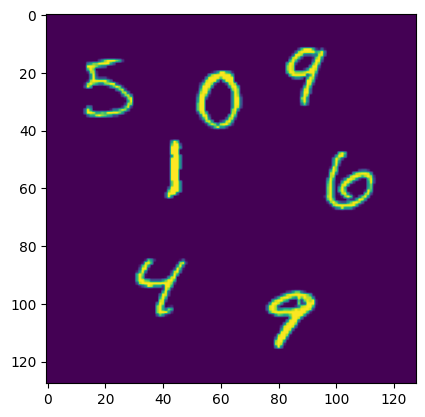

In [26]:
imageplot = plt.imshow(np.reshape(rimg,(128,128)))
plt.show()

We use the cmap function of pyplot to map classes to colors.

In [27]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(12)

def cmap1(n):
  return cmap(n)[0:3]

print(cmap1(3),cmap1(10)) # apply a RGB color to each category 

(0.38920293465748, 1.0, 0.0) (1.0, 0.0, 0.6306823551141734)


C:\Users\39392\AppData\Local\Temp\ipykernel_4972\2766553854.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


Now we try to use the fully convolutional network to "locate" digits in out sample image.

In [28]:
fmap = model_c.predict(np.expand_dims(rimg,axis=0))[0] 
print(fmap.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
(16, 16, 11)


In [29]:
fmap = np.argmax(fmap,axis=-1)
print(fmap.shape)
print(fmap)

(16, 16)
[[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10  5 10 10 10 10 10 10 10 10  4  3 10 10 10 10]
 [10  6  2 10 10 10  1  7 10  1  2  1 10 10 10 10]
 [10  3  1 10 10  1  4  2 10 10 10  1 10 10 10 10]
 [10  1  4 10 10  1  2  1 10 10 10 10 10 10 10 10]
 [10 10 10 10  7  7 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10  0  1 10 10 10 10 10  1  4  2 10 10]
 [10 10 10 10  2  3 10 10 10 10 10  8  6  3 10 10]
 [10 10 10 10 10 10 10 10 10 10 10  1  2  1 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  6  4 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  5  7  1 10 10 10  2  2 10 10 10 10 10]
 [10 10 10 10  2 10 10 10 10  8  3  1 10 10 10 10]
 [10 10 10 10 10 10 10 10 10  2  1 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10  7 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]


The result is better appreciated as a heatmap.

In [30]:
vcmap = np.vectorize(cmap1)
fcmap = np.array(vcmap(fmap))
fcmap = np.transpose(fcmap,(1,2,0))
print(fcmap.shape)

(16, 16, 3)


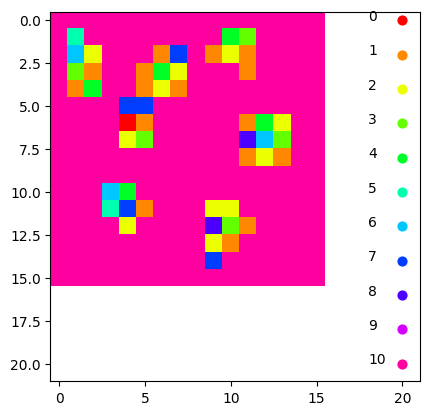

In [31]:
fig,ax = plt.subplots()
ax.imshow(fcmap)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()

Location is good but classification is not always accurate.

#Improvements

Let us try to improve things by training a classifier more robust to dispacements (mnist data are precisely centered, while the stride of the convolutional network is 8).

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        #rotation_range=0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        #shear_range=0.15,
        #zoom_range=0.15,
        horizontal_flip=False,
        fill_mode='nearest')

Let's look at sample samples of augmement data:

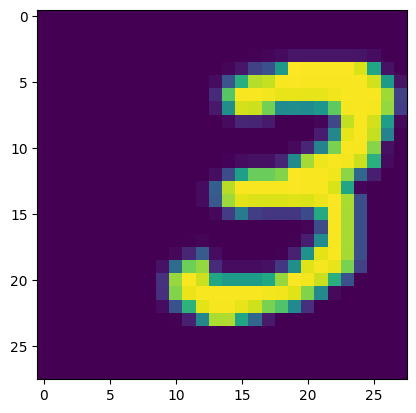

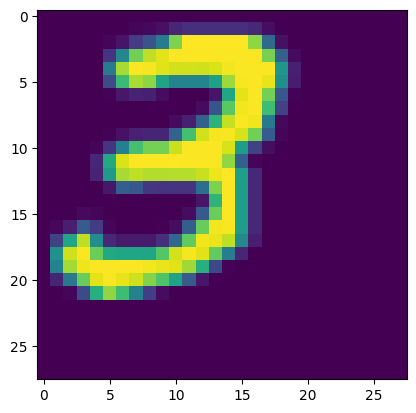

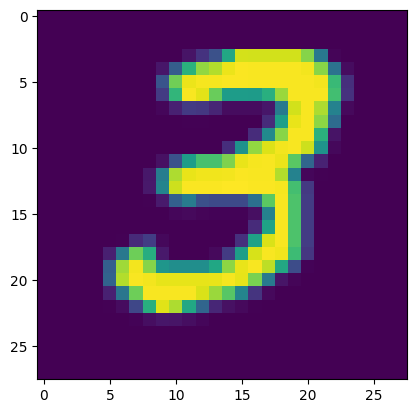

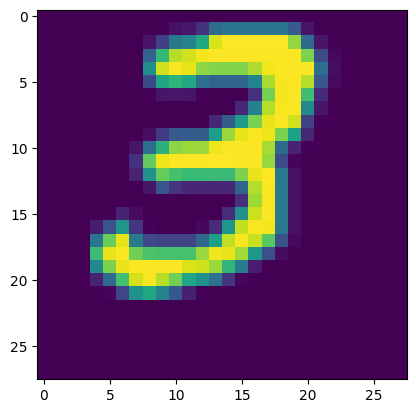

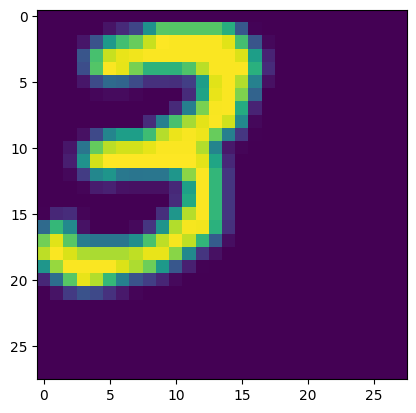

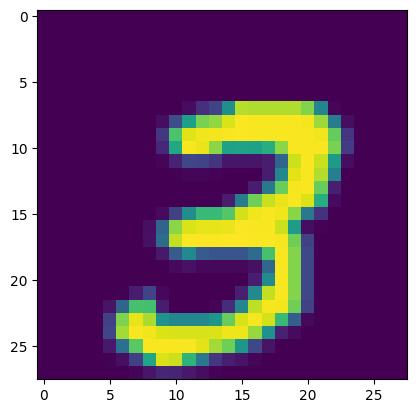

In [33]:
i = 0
for batch in datagen.flow(x_train[7:8], batch_size=1):
    i += 1
    plt.imshow(batch[0,:,:,0])
    plt.show()
    if i > 5:
        break  # otherwise the generator would loop indefinitely

In [34]:
train_generator = datagen.flow(x_train_bg,y_train_bg,batch_size=100)

In [35]:
model.fit(train_generator,
          steps_per_epoch = 600,
          epochs=5,
          validation_data=(x_test_bg, y_test_bg))

Epoch 1/5


C:\Users\39392\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.8940 - loss: 0.3537 - val_accuracy: 0.9664 - val_loss: 0.1017
Epoch 2/5
 57/600 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.9573 - loss: 0.1212

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9587 - loss: 0.1226 - val_accuracy: 0.9585 - val_loss: 0.1259
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.9611 - loss: 0.1228 - val_accuracy: 0.9663 - val_loss: 0.1057
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9679 - loss: 0.1026 - val_accuracy: 0.9732 - val_loss: 0.0825
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.9696 - loss: 0.0967 - val_accuracy: 0.9706 - val_loss: 0.0867


In [36]:
model.save_weights("C:\\Users\\39392\\phytondoc\\DeepLearning\\notebooks\\mymodel_bis.weights.h5")

In [37]:
model_c.load_weights("C:\\Users\\39392\\phytondoc\\DeepLearning\\notebooks\\mymodel_bis.weights.h5")

In [38]:
fmap = model_c.predict(np.expand_dims(rimg,axis=0))[0]
fmap = np.argmax(fmap,axis=-1)
print(fmap)
fcmap = np.array(vcmap(fmap))
fcmap = np.transpose(fcmap,(1,2,0))
print(fcmap.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10  9 10 10 10 10 10 10 10 10  4  7 10 10 10 10]
 [10  6  2 10 10 10  1  2 10 10  1  1 10 10 10 10]
 [10 10  2 10 10  1  1  1 10 10 10 10 10 10 10 10]
 [10  1  2 10 10  1  2  3 10 10 10 10 10 10 10 10]
 [10 10 10 10 10  1 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10  1  1 10 10 10 10 10  6  4  7 10 10]
 [10 10 10 10 10 10 10 10 10 10 10  6  2  3 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10  2 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  6  4 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10  2  1 10 10 10  7  7 10 10 10 10 10]
 [10 10 10 10  2 10 10 10 10  9  3  1 10 10 10 10]
 [10 10 10 10 10 10 10 10 10  1  1 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]
(16, 16, 3)


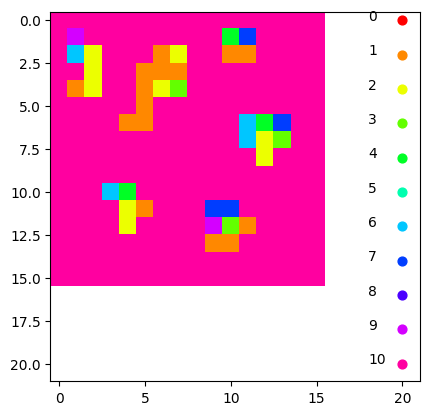

In [39]:
fig,ax = plt.subplots()
ax.imshow(fcmap)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()

As a second attemp we consider a sligtly more sophisticated classifier.

In [40]:
iimg = Input(shape=(28,28,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish')(iimg)
x = Conv2D(16,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=1,padding='same',activation='swish')(x)
x = GlobalMaxPool2D()(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) #we have now 11 categories

model2 = Model(inputs=[iimg],outputs=[cout])

In [41]:
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [42]:
model2.fit(train_generator,
          steps_per_epoch = 600,
          epochs=5,
          validation_data=(x_test_bg, y_test_bg))

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.6418 - loss: 1.0208 - val_accuracy: 0.9252 - val_loss: 0.2357
Epoch 2/5
 59/600 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.9390 - loss: 0.1944

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9444 - loss: 0.1799 - val_accuracy: 0.9422 - val_loss: 0.1725
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.9550 - loss: 0.1424 - val_accuracy: 0.9723 - val_loss: 0.0832
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9677 - loss: 0.1023 - val_accuracy: 0.9647 - val_loss: 0.1080
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.9696 - loss: 0.0952 - val_accuracy: 0.9791 - val_loss: 0.0623


In [43]:
model2.save_weights("C:\\Users\\39392\\phytondoc\\DeepLearning\\notebooks\\mymodel2.weights.h5")

Now we convolutionalize the previous calssifier. In this case, we also leave a pooling layer after the convolution. Since we do not want to further decrease the spatial dimension of the feature map, we apply it with stride 1 (the default stride for pooling layers is equal to the dimension of the kernel).

In [44]:
iimg = Input(shape=(None,None,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish')(iimg)
x = Conv2D(16,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=1,padding='same',activation='swish')(x)
x = MaxPool2D((3,3),padding='same',strides=1)(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) 

model2_c = Model(inputs=[iimg],outputs=[cout])

In [45]:
model2_c.load_weights("C:\\Users\\39392\\phytondoc\\DeepLearning\\notebooks\\mymodel2.weights.h5")

In [46]:
fmap = model2_c.predict(np.expand_dims(rimg,axis=0))[0]
fmap = np.argmax(fmap,axis=-1)
print(fmap)
fcmap = np.array(vcmap(fmap))
fcmap = np.transpose(fcmap,(1,2,0))
print(fcmap.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
[[ 5  1  1 10 10 10 10 10 10  9  9  9  5 10 10 10]
 [ 5  5  3  3  0 10  0  0  9  9  9  9  9 10 10 10]
 [ 5  5  5  5  5  0  0  0  0  9  9  7  5 10 10 10]
 [ 5  5  5  5  0  0  0  0  0  7  7  7  5 10 10 10]
 [ 5  5  5  5  1  1  0  0  0 10 10 10 10 10 10 10]
 [10 10 10 10  1  1  1 10 10 10 10  6  6  0  0 10]
 [10 10 10 10  1  1  1 10 10 10  6  6  6  6  5 10]
 [10 10 10  1  1  1  1 10 10 10  6  6  6  6  5 10]
 [10 10 10 10 10 10 10 10 10 10  8  6  6  6  5 10]
 [10 10 10 10  6  6 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  4  4  4  1 10 10  9  2  2 10 10 10 10]
 [10 10  5  4  4  4  4 10  9  9  9  7 10 10 10 10]
 [10 10 10  4  4  4  5 10  9  9  9  7  0 10 10 10]
 [10 10 10 10 10 10 10 10  7  8  8  7 10 10 10 10]
 [10 10 10 10 10 10 10 10 10  3  5  5 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]
(16, 16, 3)


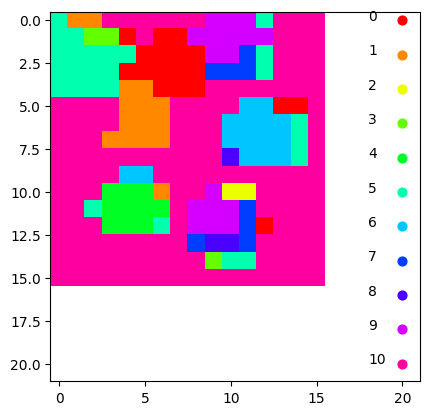

In [47]:
fig,ax = plt.subplots()
ax.imshow(fcmap)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()